In [194]:
import pandas as pd
import numpy as np
from plotnine import *
from scipy.stats import gmean

In [195]:
def filter_v2flayout(result):
    # remove rows with 'cx', 'zzphase', 'sqisw' column properties are all 1
    return result[~((result['cx'] == 1) & (result['zzphase'] == 1) & (result['sqisw'] == 1) & (result['can_xx'] == 1) & (result['can_xy'] == 1))]
    

In [196]:
result_sabre_chain = filter_v2flayout(pd.read_csv('../results/sabre-chain.csv'))
result_canopus_chain = filter_v2flayout(pd.read_csv('../results/canopus-chain.csv'))
result_sabre_hhex = filter_v2flayout(pd.read_csv('../results/sabre-hhex.csv'))
result_canopus_hhex = filter_v2flayout(pd.read_csv('../results/canopus-hhex.csv'))
result_sabre_square = filter_v2flayout(pd.read_csv('../results/sabre-square.csv'))
result_canopus_square = filter_v2flayout(pd.read_csv('../results/canopus-square.csv'))

ISA_TYPES = ['cx', 'zzphase', 'sqisw', 'can_xx', 'can_xy']

In [197]:
for isa in ISA_TYPES:
    print(f'ISA: {isa}')
    chain_outliers = (result_canopus_chain['program'].iloc[np.where(result_canopus_chain[isa] / result_sabre_chain[isa] > 1)[0]]).tolist()
    hhex_outliers = (result_canopus_hhex['program'].iloc[np.where(result_canopus_hhex[isa] / result_sabre_hhex[isa] > 1)[0]]).tolist()
    square_outliers = (result_canopus_square['program'].iloc[np.where(result_canopus_square[isa] / result_sabre_square[isa] > 1)[0]]).tolist()
    print('chain outliers:', chain_outliers)
    print('hhex outliers:', hhex_outliers)
    print('square outliers:', square_outliers)
    print('')


ISA: cx
chain outliers: ['dnn_n16']
hhex outliers: ['ising_n26']
square outliers: []

ISA: zzphase
chain outliers: ['dnn_n16', 'multiplier_n15']
hhex outliers: ['multiplier_n15']
square outliers: []

ISA: sqisw
chain outliers: ['dnn_n16']
hhex outliers: []
square outliers: []

ISA: can_xx
chain outliers: ['dnn_n16']
hhex outliers: []
square outliers: []

ISA: can_xy
chain outliers: ['dnn_n16']
hhex outliers: ['ising_n26']
square outliers: []



In [212]:
len(result_canopus_chain), len(result_canopus_hhex), len(result_canopus_square)

(13, 17, 12)

In [115]:
# hhex, cx; hhex, zzphase

8     multiplier_n15
11           qft_n18
12       qpeexact_16
Name: program, dtype: object

Series([], Name: program, dtype: object)

In [117]:
result_sabre_square

,program,num_qubits,cx,zzphase,sqisw,can_xx,can_xy
0,bigadder_n18,18,1.693182,1.773333,1.449367,2.046667,1.346667
1,bv_n19,19,2.055556,2.000000,1.666667,2.000000,1.611111
4,gcm_n13,13,1.550980,1.995513,1.326260,1.923106,1.381181
7,knn_n25,25,1.790323,2.250000,1.510000,1.977273,1.659091
8,multiplier_n15,15,1.857143,1.847458,1.393443,1.961864,1.351695
9,qec9xz_n17,17,1.833333,2.250000,1.791667,2.333333,1.375000
10,qf21_n15,15,1.437500,2.512545,1.476562,3.936078,2.361226
11,qft_n18,18,2.727273,6.684615,3.045455,9.853281,6.073589
12,qpeexact_16,16,2.697674,4.711340,2.620690,5.937095,3.928475
13,qram_n20,20,1.910256,2.090909,1.321429,2.060606,1.515152


In [259]:
def plot_avg_comp(result_sabre, result_canopus, title):

    avg_overhead_sabre = [gmean(result_sabre[isa]) for isa in ISA_TYPES]
    avg_overhead_canopus = [gmean(result_canopus[isa]) for isa in ISA_TYPES]

    reductions = ['-{}%'.format(round(100 * (1 - gmean(result_canopus[isa] / result_sabre[isa])), 2)) for isa in ISA_TYPES]

    comp = pd.DataFrame({
        'ISA': ISA_TYPES,
        'Sabre': avg_overhead_sabre,
        'Canopus': avg_overhead_canopus
    })

    # 创建标注数据框，包含每个ISA对应的reduction值
    annotation_data = pd.DataFrame({
        'ISA': ISA_TYPES,
        'reduction': reductions,
        'y_pos': [min(avg_overhead_sabre[i], avg_overhead_canopus[i]) * 1.05 for i in range(len(ISA_TYPES))],
        'x_pos': [i + 1.25 for i in range(len(ISA_TYPES))]
    })

    p_avg_comparison = (
    comp
    .melt(id_vars='ISA', var_name='Method', value_name='Overhead')
    .assign(
        Method=lambda df: df['Method'].astype('category'),
        ISA=lambda df: pd.Categorical(
            df['ISA'],
            categories=ISA_TYPES,
            ordered=True
        )
    )
    .pipe(lambda df: df.assign(Method=df['Method'].cat.reorder_categories(['Sabre', 'Canopus'])))
    .pipe(lambda df: (
        ggplot(df, aes(x='ISA', y='Overhead', fill='Method')) +
        geom_bar(stat='identity', position='dodge', alpha=0.8) +
        geom_text(data=annotation_data,
                mapping=aes(x='x_pos', y='y_pos', label='reduction'),
                size=10, ha='center', va='bottom', inherit_aes=False) +
        labs(title=title, x='', y='') +
        scale_fill_manual(values=['#3498DB','#E74C3C']) +
        theme_minimal() +
        theme(
            axis_text_x=element_text(rotation=0, hjust=0.5, size=12),
            axis_text_y=element_text(size=12),
            legend_title=element_blank(),
            legend_position=(0.975,0.975),
            legend_text=element_text(size=13),
            figure_size=(6, 3.5),
            plot_title=element_text(size=16, face='bold'),
            plot_subtitle=element_text(size=12, face='italic')
            )
        ))
    )
    return p_avg_comparison

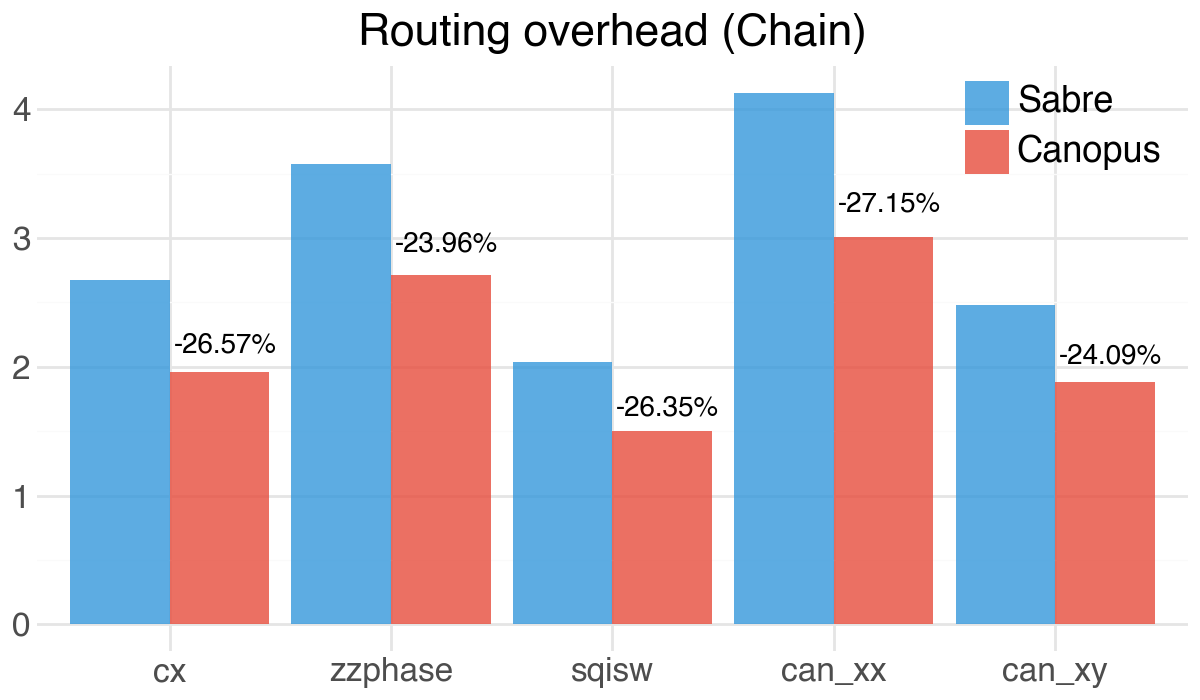

In [260]:
plot_avg_comp(result_sabre_chain, result_canopus_chain, 'Routing overhead (Chain)')


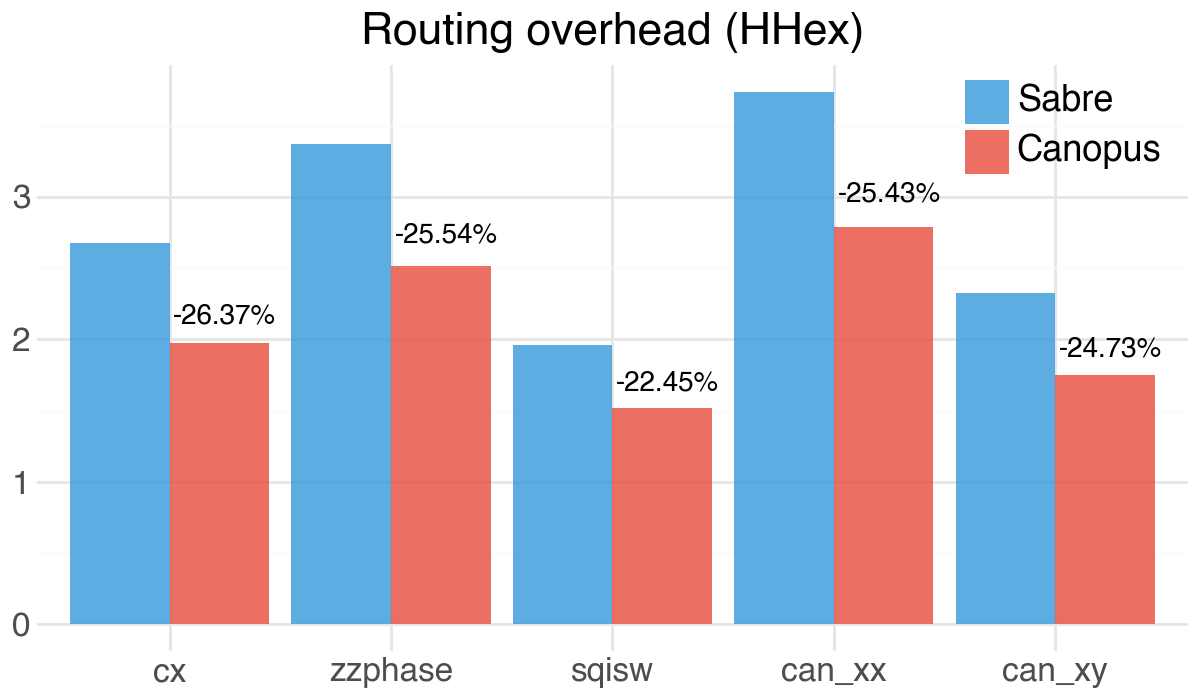

In [261]:
plot_avg_comp(result_sabre_hhex, result_canopus_hhex, 'Routing overhead (HHex)')

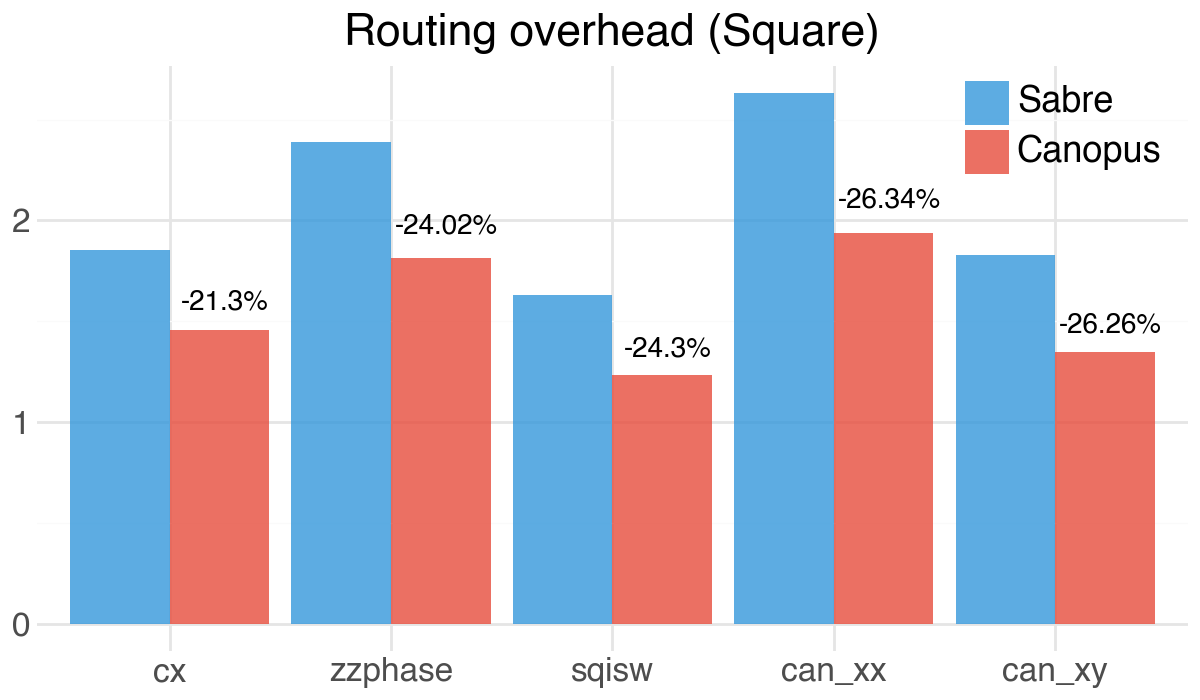

In [262]:
plot_avg_comp(result_sabre_square, result_canopus_square, 'Routing overhead (Square)')